SKI (Structured Kernel Interpollation)or KISS-GP is a great way to scale a GP up to very large datasets (100,000+ data points). Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper: http://proceedings.mlr.press/v37/wilson15.pdf

In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Make plots inline
%matplotlib inline

# 1. Data Processing

In [4]:
#read the data and create data frame
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


note in below block, I don't use reshape(-1, 1) as what we do in sklearn. This is for later tensor shape

In [5]:
train_size = 200 #at the head
test_size = 100 #in the middle
train_size2 = 200 #at the tail
split = train_size + test_size + train_size2

#get training set
train = df[0:train_size].append(df[train_size + test_size:split]) 
X_train = np.array(train['time'])
Y_train = np.array(train['Y'])

#get testing set
test = df[train_size-1:train_size+test_size+1]
X_test = np.array(test['time'])
Y_test = np.array(test['Y'])

# Below df are only used for poltting the data
# we add nan in between 2 parts of training data to avoid the straight line between twp training set in later plotting
df_train_two_side = df.copy(deep=True)
df_train_two_side['Y'][train_size:train_size+test_size] = np.nan
train_2_side = df_train_two_side[0:split]
X_train_with_nan = np.array(train_2_side['time'])
Y_train_with_nan = np.array(train_2_side['Y'])  

/var/folders/ts/xc6_h0kd5nv7gws_x4n04jwr0000gn/T/ipykernel_38492/1968101614.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df[0:train_size].append(df[train_size + test_size:split])


convert data into tensor format 

In [6]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

X_train_with_nan = torch.tensor(X_train_with_nan)
Y_train_with_nan = torch.tensor(Y_train_with_nan) 

# 2. Implement GP model with GpyTorch

In [7]:
#import the self-design kernel from gpytorch_design_kernel
from GpyTorch_custom_kernel import WhiteKernel, FirstSincKernel

In [8]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. 
        # Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). 
        # Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        #we are going to warpping below kernel inside the interpolation kernel 
        self.base_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.RBFKernel() + FirstSincKernel())

        #Exp-Sine-Squared kernel (aka periodic kernel)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                self.base_kernel, grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [9]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, Y_train, likelihood)

In [10]:
training_iterations =  4

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    loss.backward()
    optimizer.step()

diff1 tensor([[[1.0000e-15, 6.3554e-01, 1.2711e+00, 1.9066e+00, 2.5422e+00,
          3.1777e+00, 3.8133e+00, 4.4488e+00, 5.0843e+00, 5.7199e+00,
          6.3554e+00, 6.9910e+00, 7.6265e+00, 8.2620e+00, 8.8976e+00,
          9.5331e+00, 1.0169e+01, 1.0804e+01, 1.1440e+01, 1.2075e+01,
          1.2711e+01, 1.3346e+01, 1.3982e+01, 1.4617e+01, 1.5253e+01,
          1.5889e+01, 1.6524e+01, 1.7160e+01, 1.7795e+01, 1.8431e+01,
          1.9066e+01, 1.9702e+01, 2.0337e+01, 2.0973e+01, 2.1608e+01,
          2.2244e+01, 2.2880e+01, 2.3515e+01, 2.4151e+01, 2.4786e+01,
          2.5422e+01, 2.6057e+01, 2.6693e+01, 2.7328e+01, 2.7964e+01,
          2.8599e+01, 2.9235e+01, 2.9870e+01, 3.0506e+01, 3.1142e+01,
          3.1777e+01, 3.2413e+01, 3.3048e+01, 3.3684e+01, 3.4319e+01,
          3.4955e+01, 3.5590e+01, 3.6226e+01, 3.6861e+01, 3.7497e+01,
          3.8133e+01, 3.8768e+01, 3.9404e+01, 4.0039e+01, 4.0675e+01,
          4.1310e+01, 4.1946e+01, 4.2581e+01, 4.3217e+01, 4.3852e+01,
          4.44

In [2]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

NameError: name 'model' is not defined

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_prediction = likelihood(model(X_train))
    train_mean = train_prediction.mean
    test_prediction = likelihood(model(X_test))
    test_mean = test_prediction.mean
    # Get lower and upper predictive bounds
    train_lower, train_upper = train_prediction.confidence_region()
    test_lower, test_upper = test_prediction.confidence_region()

/Users/zhanghanyuan/opt/anaconda3/envs/timeseries/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [12]:
test_prediction

MultivariateNormal(loc: torch.Size([102]))

In [13]:
#add nan in the middle of testing prediction, use for later plotting
y_pred_train_with_nan = d = np.concatenate((np.array(train_mean[0:train_size])\
    , np.array([np.nan for i in range(test_size)]), np.array(train_mean[train_size:]))) 
y_pred_test = np.array(test_mean)

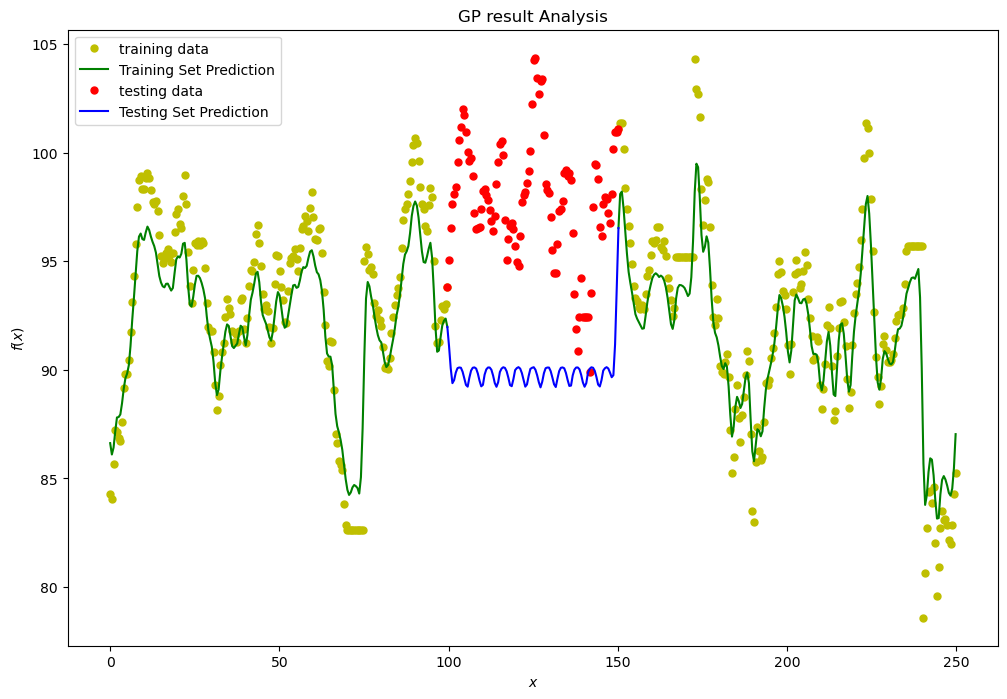

In [14]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(12,8))

#plot training data
plt.plot(X_train_with_nan, Y_train_with_nan, 'y.', markersize=10, label='training data')

# plot training prediction
plt.plot(X_train_with_nan, y_pred_train_with_nan, 'g-', label='Training Set Prediction')

#plot testing data
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data')

#plot testing prediction
plt.plot(X_test, y_pred_test, 'b-', label='Testing Set Prediction')

#add CI
# plt.fill_between(np.squeeze(X_test), (y_pred_test- ci).ravel(), (y_pred_test+ ci).ravel(), color='blue',alpha = 0.2)

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()